# k-nearest neighbors

Only use the already imported libraries `numpy` and `matplotlib.pyplot` for the assignment. Do not import any other library. 

In [9]:
import matplotlib.pyplot as plt
import numpy as np


def load_iris_dataset():
    from sklearn import datasets
    iris = datasets.load_iris()
    X = iris.data
    y = iris.target
    return X, y
    
X, y = load_iris_dataset()

## Task 1: Visualization and Preprocessing

1) Explain the content of the dataset in few words. What are the input features? What is the classification target? Check out: [https://en.wikipedia.org/wiki/Iris_flower_data_set](https://en.wikipedia.org/wiki/Iris_flower_data_set).


The dataset contains a set of 150 records under four features
- sepal length
- sepal width
- petal length
- petal width

The dataset contains 3 different classification targets
- Iris setosa - 0
- Iris versicolor - 1
- Iris virginica - 2

2) Compute and print the following statistics about the dataset:
  - Number of samples
  - Number of samples per class
  - Mean and standard deviation for each input feature


In [10]:
classes=["Iris setosa","Iris versicolor","Iris virginica"]
features=["sepal length","sepal width","petal length","petal width"]
np.random.seed(0)
n_samples=X.shape[0]
n_samples_class=np.zeros(len(classes))
for i in y:
    n_samples_class[0]+=1 if i==0 else 0
    n_samples_class[1]+=1 if i==1 else 0
    n_samples_class[2]+=1 if i==2 else 0

mean=np.mean(X,axis=0)
std=np.std(X,axis=0)
print("The number of samples: %i"%n_samples)
for i, c in enumerate(n_samples_class):
    print("The number of samples per class %s: %i"%(classes[i],c))
for i,v in enumerate(zip(mean,std)):
    print("The mean and standard deviation of %s feature: (%f,%f)"%(features[i],v[0],v[1]))

The number of samples: 150
The number of samples per class Iris setosa: 50
The number of samples per class Iris versicolor: 50
The number of samples per class Iris virginica: 50
The mean and standard deviation of sepal length feature: (5.843333,0.825301)
The mean and standard deviation of sepal width feature: (3.054000,0.432147)
The mean and standard deviation of petal length feature: (3.758667,1.758529)
The mean and standard deviation of petal width feature: (1.198667,0.760613)


3) Visualize the variables Sepal length and Petal length in a scatter plot (Sepal length on the x-axis, petal length on the y-axis). Color each point of the plot according to its class.

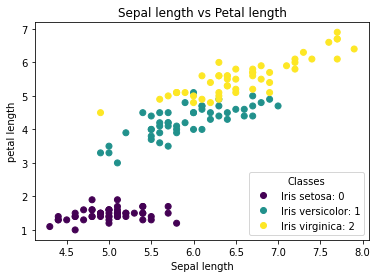

In [11]:
classes_indx=["Iris setosa: 0","Iris versicolor: 1","Iris virginica: 2"]
fig, ax=plt.subplots()
scatter=ax.scatter(X[:,0], X[:,2], c=y)
handles, _ = scatter.legend_elements()
ax.legend(handles,classes_indx,loc="lower right",title="Classes")
ax.set_xlabel('Sepal length')
ax.set_ylabel('petal length')
ax.set_title('Sepal length vs Petal length')
plt.show()

4) Split the dataset randomly into training and test data. 70% of data should be used for training and 30% should be used for testing. Implement the function `train_test_split`. Do not modify the interface of the function.

In [12]:
def train_test_split(X, y):
    """
    Returns X_train, X_test, y_train, y_test, 
        where X_train and X_test are the input features of the training and test set,
        and y_train and y_test are the class labels of the training and test set.
    """
    choice = np.random.choice(range(X.shape[0]), size=(int(0.7*X.shape[0]),), replace=False)
    ind = np.zeros(X.shape[0], dtype=bool)
    ind[choice] = True
    X_train=X[ind == True,:]
    X_test=X[ind == False,:]
    y_train=y[ind == True,]
    y_test=y[ind == False,]
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y)
assert (X_train.shape[0] + X_test.shape[0]) == X.shape[0]
assert (y_train.shape[0] + y_test.shape[0]) == y.shape[0]
assert X_train.shape[1] == X_test.shape[1]

5) kNN uses a distance measure to identify close neighbors. If the input features are not of the same scale, the distance is not as meaningful, which can negatively impact classification performance. Perform min-max scaling (i.e. scale the values of the input features in such a way that their range is from 0 to 1) on the training and test data. Remember that you should only use information from the training data to perform the scaling on both data sets.

In [13]:
X_test=(X_test-np.min(X_train,axis=0))/(np.max(X_train,axis=0)-np.min(X_train,axis=0))
X_train=(X_train-np.min(X_train,axis=0))/(np.max(X_train,axis=0)-np.min(X_train,axis=0))

## Task 2: k-nearest neighbors

**For B.Sc. Data Science:**  
Implement the kNN algorithm with uniform weighting and arbitrary `k`. Fill out the `predict` method of class `KNearestNeighborsClassifier`. 

Use Euclidean distance to determine the nearest neighbors.
You can ignore the optional parameter `distance_metric`, which is provided as a field in the kNN class.

**For everyone else:**  
Implement the kNN algorithm with distance-based weighting and arbitrary `k`.
Fill out the `predict` method of class `KNearestNeighborsClassifier`.

The parameter `distance_metric` will either contain the string `uniform` or a function. If the value is `uniform`, the classifier should use the Euclidean distance for determining nearest neighbors and uniform weighting. If the value is a function, the classifier should use the function as distance metric and perform distance-weighted classification. An example distance metric is provided with `euclidean_distance`.

In [14]:
class KNearestNeighbors(object):
    def __init__(self, k, distance_metric='uniform'):
        self.k = k
        self.distance_metric = distance_metric
        
    def fit(self, X, y):
        """
        This functions saves the training data to be used during the prediction.
        """
        self.X = X
        self.y = y
    
    def predict(self, X):
        """
        Returns a vector of shape (n,) if X has shape (n,d), 
        where n is the number of samples and d is the number of features.
        """
        y_pred=[]
        for x in X:
            if self.distance_metric=='uniform':
                distance=np.array([euclidean_distance(x,data_point) for data_point in self.X])
            else:
                distance=np.array([self.distance_metric(x,data_point) for data_point in self.X])
            ind=np.argsort(distance)
            y_predicted = self.y[ind[0:self.k]]
            if self.distance_metric=='uniform':
                weights=np.array([1.0/self.k for _ in range(self.k)])
            else:
                inv_distance=1.0/(distance[ind[0:self.k]]+1e-8)
                inv_distance_sum=np.sum(inv_distance)
                weights=inv_distance/inv_distance_sum
            y_pred.append(np.bincount(y_predicted,  weights=weights).argmax())
                
        return np.array(y_pred)
    
def euclidean_distance(x1, x2):
    """
    Given vectors x1 and x2 with shape (n,) returns distance between vectors as float.
    """
    return np.sqrt(np.sum((x1 - x2)*(x1 - x2)))

## Task 3: Evaluation

1) Implement functions to compute precision, recall and F1-score. `y_pred` and `y_true` are the vectors of predicted and true class labels respectively with shape `(n,)`, where `n` is the number of samples. Each function should return a float containing the corresponding score.

In [15]:
def precision(y_pred, y_true):
    true_positive=np.zeros(len(classes))
    for pred, true in zip(y_pred,y_true):
        true_positive[true]+=1 if pred == true else 0
    counts_pred=np.array([np.count_nonzero(y_pred == data_point) for data_point in [0,1,2]])
    precision = np.divide(true_positive, counts_pred) 
    if precision.any() == np.nan:
        precision = np.divide(true_positive, counts_pred+1e-12) 
    return np.mean(precision)

def recall(y_pred, y_true):
    true_positive=np.zeros(len(classes))
    for pred, true in zip(y_pred,y_true):
        true_positive[true]+=1 if pred == true else 0
    counts_true=np.array([np.count_nonzero(y_true == data_point) for data_point in [0,1,2]])
    recall = np.divide(true_positive, counts_true) 
    if recall.any() == np.nan:
        recall = np.divide(true_positive, counts_true+1e-12)   
    return np.mean(recall)

def f1score(y_pred, y_true):
    p = precision(y_pred, y_true)
    r = recall(y_pred, y_true)
    return (2*r*p)/(r+p)

2) Evaluate the performance of kNN with uniform weighting on the Iris dataset for `k=1,3,5`. Train each of the `3` classifiers on the training data from Task 1. Perform the predictions on both the training and test data. Then compute precision, recall, and F1-score for each model and for both training and test data. Print all scores per model. What do you observe?

**For all students other than B.Sc. Data Science:** 
Evaluate the kNN classifier with Euclidean distance-weighting. Compare the performance to uniform-weighting. How does the performance change compared to uniform weighting for each `k`?

In [16]:
import time
start=time.time()
for k in [1,3,5]:
    KNN=KNearestNeighbors(k=k,distance_metric='uniform')
    KNN.fit(X_train,y_train)
    y_pred=KNN.predict(X_train)
    print('uniform classifier with k ={}'.format(k))
    print('\tprecision for training data : {}'.format(precision(y_pred,y_train)))
    print('\trecall for training data : {}'.format(recall(y_pred,y_train)))
    print('\tf1 score for training data : {}'.format(f1score(y_pred,y_train)))
    y_pred=KNN.predict(X_test)
    print('\tprecision for test data : {}'.format(precision(y_pred,y_test)))
    print('\trecall for test data : {}'.format(recall(y_pred,y_test)))
    print('\tf1 score for test data : {}'.format(f1score(y_pred,y_test)))
    KNN=KNearestNeighbors(k=k,distance_metric=euclidean_distance)
    KNN.fit(X_train,y_train)
    y_pred=KNN.predict(X_train)
    print('distance weighted classifier with k ={}'.format(k))
    print('\tprecision for training data : {}'.format(precision(y_pred,y_train)))
    print('\trecall for training data : {}'.format(recall(y_pred,y_train)))
    print('\tf1 score for training data : {}'.format(f1score(y_pred,y_train)))
    y_pred=KNN.predict(X_test)
    print('\tprecision for test data : {}'.format(precision(y_pred,y_test)))
    print('\trecall for test data : {}'.format(recall(y_pred,y_test)))
    print('\tf1 score for test data : {}'.format(f1score(y_pred,y_test)))

print(time.time()-start)

uniform classifier with k =1
	precision for training data : 1.0
	recall for training data : 1.0
	f1 score for training data : 1.0
	precision for test data : 0.9523809523809524
	recall for test data : 0.9583333333333334
	f1 score for test data : 0.9553478712357217
distance weighted classifier with k =1
	precision for training data : 1.0
	recall for training data : 1.0
	f1 score for training data : 1.0
	precision for test data : 0.9523809523809524
	recall for test data : 0.9583333333333334
	f1 score for test data : 0.9553478712357217
uniform classifier with k =3
	precision for training data : 0.9628482972136223
	recall for training data : 0.9628482972136223
	f1 score for training data : 0.9628482972136223
	precision for test data : 0.9743589743589745
	recall for test data : 0.9791666666666666
	f1 score for test data : 0.9767569045665847
distance weighted classifier with k =3
	precision for training data : 1.0
	recall for training data : 1.0
	f1 score for training data : 1.0
	precision fo

==> *Write your observations here and report your results.* (double klick here to edit)

3) Explain why kNN with `k=1` achieves perfect results on the training data. Why is it not the best model?

==> *Write your response here.* (double klick here to edit)